In [205]:
import math
import numpy as np
import matplotlib.pyplot as plt

import random

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [6]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [8]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

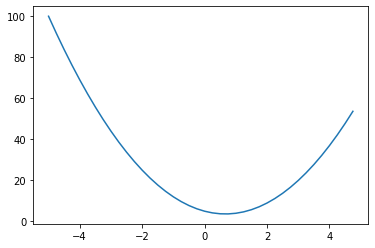

In [9]:
plt.plot(xs, ys)

In [13]:
h = 0.001
x = 3.0

(f(x+h) - f(x))/h

14.00300000000243

In [14]:
a = 12.0
b = -2.0
c = 4.0
d = a*b +c
print(d)

-20.0


In [25]:


h == 0.00001

#inputs
a = 12.0
b = -2.0
c = 4.0

d1 = a*b +c

c += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)



d1 -20.0
d2 -19.999
slope 1.0000000000012221


In [18]:
def f(a):
    b = -2.0
    c = 4.0
    return a*b + c

h = 0.001
a = 12.0
d1 = f(a)
d2 = f(a + h)

print('slope', (d2 - d1)/h)


slope -1.9999999999988916


In [749]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        
        return out
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out 
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad 
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self*other
    def __radd__(self, other):
        return self + other
    def __rsub__(self, other):
        return other + (-self)
    
    def __truediv__(self, other): # self/other
        return self*other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1 )/(math.exp(2*x) + 1)
        out = Value(t, (self, ), _op='tanh')
        
        def _backward():
            self.grad += 1 - (t**2) * out.grad    
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b
e.label='e'

d = e+c; d.label='d'

f = Value(-2.0, label='f')

L = d*f
L.label='L'

L

Value(data=-8.0)

In [670]:
q = Value(2.0)
p = Value(4.0)
p-q

Value(data=2.0)

In [556]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [283]:
d._op

'+'

In [284]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid=str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
    


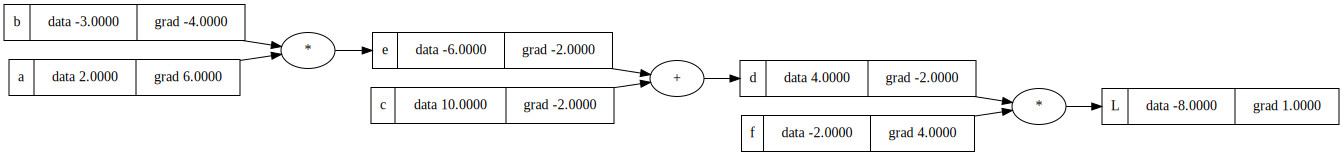

In [110]:

draw_dot(L)

In [109]:
L.grad = 1
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [106]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    e = a*b
    e.label='e'

    d = e+c; d.label='d'

    f = Value(-2.0, label='f')

    L = d*f
    L.label='L'

    L1 = L.data


    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')

    e = a*b
    e.label='e'

    d = e+c; d.label='d'

    f = Value(-2.0, label='f')

    L = d*f
    L.label='L'

    L2 = L.data
    

    print((L2 - L1)/h)
    
lol()

6.000000000021544


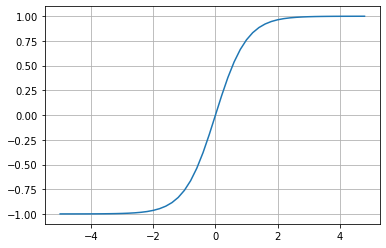

In [113]:
xs = np.arange(-5.0, 5.0, 0.2)
ys = np.tanh(xs)
plt.plot(xs, ys)
plt.grid()

In [167]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')



x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'


n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'


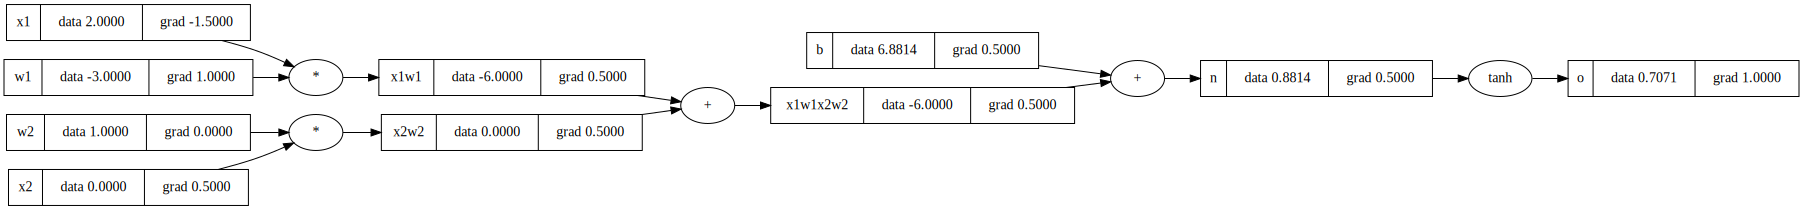

In [170]:
draw_dot(o)

In [169]:
o.backward()

In [162]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [157]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()

In [142]:
o.grad = 1.0
n.grad = 1 - (o.data**2) # deriv of tanh function

x1w1x2w2.grad = n.grad
b.grad = n.grad

x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data


In [ ]:
### diff tanh

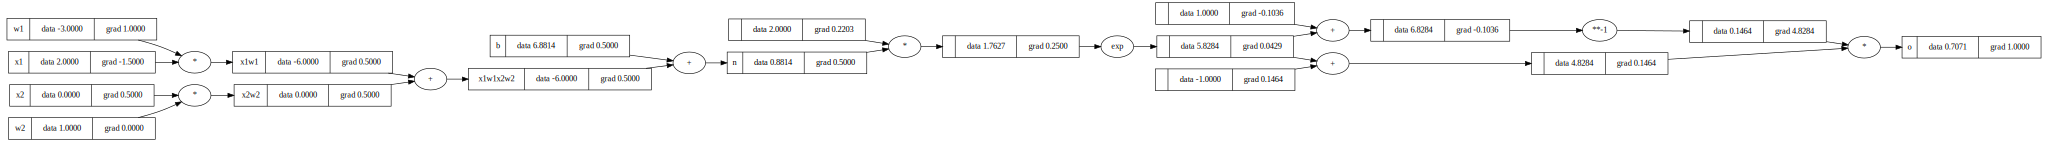

In [199]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')



x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'


n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

In [612]:
from typing import List

In [750]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        #w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
    
class Layer:
    def __init__(self, num_inputs, num_outputs):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
         
class MLP:
    def __init__(self, num_inputs:int, layer_sizes:List):
        size = [num_inputs] + layer_sizes
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(layer_sizes))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def paramters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [751]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7370669239190257)

In [752]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]




In [753]:
ypred = [n(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.567285198439461)

In [827]:
ypred = [n(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.292489717368533)

In [828]:
loss.backward()

In [829]:
for p in n.paramters():
    p.data += -0.001 * p.grad # minus to minimise the loss

In [830]:
ypred

[Value(data=-0.6874375985474515),
 Value(data=-0.6886132340356776),
 Value(data=-0.6723525377585113),
 Value(data=-0.800202624941408)]